In [306]:
import pandas as pd
import numpy as np
from numpy.random import choice

import scipy
from scipy.stats import spearmanr, pearsonr
import scipy.cluster.hierarchy as sch
from scipy.spatial import distance

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [282]:
def autolabel(rects, axis):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        axis.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

## Define preprocessing function

In [475]:
def import_data():
    # Import data

    col_names = pd.read_csv("communities_names.csv", header = None)
    list_of_column_names = []

    for index, row_data in col_names.iterrows():
        list_of_column_names.append(str(row_data[0]))

    data = pd.read_csv("communities_data.csv", names = list_of_column_names)

    # Remove categorical columns 
    # 1: county and communities have many missing values
    # 2: communityname would be a direct indicator of crime and should be removed
    # 3: state is not that important

    data.drop(labels = ["state", "county", "community", "communityname"],axis = 1, inplace = True)

    # We also remove the fold-column since this is only present for reproducing article findings

    data.drop(labels = ["fold"],axis = 1, inplace = True)

    # Drop columns with missing data
    col_names_missing_vals = pd.read_csv("communities_names_missing.csv", header = None)
    list_of_column_names_missing_vals = []

    for index, row_data in col_names_missing_vals.iterrows():
        list_of_column_names_missing_vals.append(str(row_data[0]))


    data.drop(labels = list_of_column_names_missing_vals,axis = 1, inplace = True)    
    
    # Make data_init
    data_init = data.copy()
    
    # Make a categorical column for blackness where we set a threshold (just for visualization purposes)
    racepctblack = np.asarray(data.racepctblack)
    threshold = 0.15 # Previously 0.4
    IsBlack = [1 if x>threshold else 0 for x in racepctblack]
    data["IsBlack"] = IsBlack

    # Make a categorical column for crime
    crime_rate = np.asarray(data.ViolentCrimesPerPop)
    threshold_crime = np.quantile(data_init.ViolentCrimesPerPop, 0.70)
    HighCrime = [1 if x>threshold_crime else 0 for x in crime_rate]
    data["HighCrime"] = HighCrime
    
    # Make a full dataframe where we have not removed the protected columns or the label
    data_full = data.copy()
    
    # Remove protected features and put into separate dataframe
    # Note: this includes all racepct-columns (black, white, asian, hipspanic), since one can be somewhat derived from the others
    protected_cols = ["IsBlack", "racepctblack", "racePctWhite", "racePctAsian", "racePctHisp"]
    data_protected = pd.concat([data.pop(x) for x in protected_cols], axis=1)
    
    # Remove y column (the label)
    y_cols = ["ViolentCrimesPerPop", "HighCrime"]
    data_y = pd.concat([data.pop(x) for x in y_cols], axis=1)
    
    return data_init, data_full, data, data_protected, data_y


In [476]:
df_init, df_all, df, df_protected, df_y = import_data()

Descriptions:

- **df_init** Has all columns where there is no missing data and which are not continuous. Does not have the user defined threhold-columns (IsBlack and HighCrime)
- **df_all** Has all columns where there is no missing data and which are not continuous, including IsBlack and HighCrime which are defined using threholds
- **df** Has all columns with no missing data and which are not continuous and which are neither protected or the target value
- **df_protected** Has protected columns: "IsBlack", "racepctblack", "racePctWhite", "racePctAsian", "racePctHisp"
- **df_y** Has y-column (both continuous and threhold): "ViolentCrimesPerPop", "HighCrime"

In [477]:
Number_of_pca_dimensions = 2

In [478]:
print("Number of dimensions prior to pca:", len(df.columns))

Number of dimensions prior to pca: 95


# Using PCA to get most similar neighbourhoods in 2D

explained variance ratio (first two components): [0.27389422 0.1834014 ]


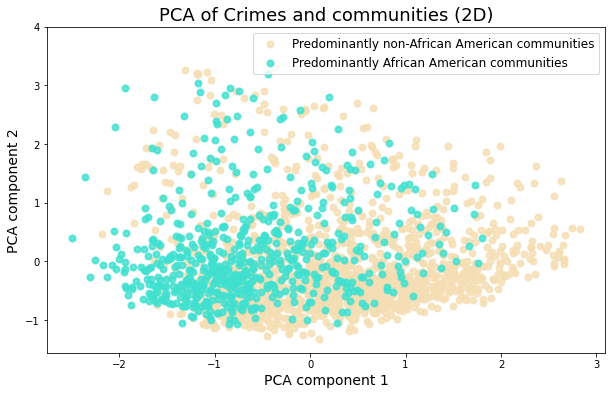

In [479]:
from sklearn.decomposition import PCA

X = df
y = df_all.IsBlack
target_names = ["Predominantly non-African American communities", "Predominantly African American communities"]

pca = PCA(n_components=Number_of_pca_dimensions)
X_r = pca.fit(X).transform(X)

# Percentage of variance explained for each components
print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)

plt.figure(figsize = (10,6))
colors = ["wheat", "turquoise"]
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )

plt.ylim(top = 4)
plt.xlabel("PCA component 1", fontsize = 14)
plt.ylabel("PCA component 2", fontsize = 14)


plt.legend(loc="best", shadow=False, scatterpoints=1, fontsize = 12)
plt.title("PCA of Crimes and communities (2D)", fontsize = 18)

plt.savefig("Plots/PCA_2D.png")

plt.show()

In [480]:
black_pca = []

for i in range(len(X_r[y == 1, 0])):
    point = (X_r[y == 1, 0][i], X_r[y == 1, 1][i])
    black_pca.append(point)
    
white_pca = []

for i in range(len(X_r[y == 0, 0])):
    point = (X_r[y == 0, 0][i], X_r[y == 0, 1][i])
    white_pca.append(point)



# Analysis

In [481]:
# Pick 10 random white neighbourhoods between -1 and 1 on both axes (most points in these regions)
N_clusters = 10
np.random.seed(43)

white_pca_subset = np.asarray(white_pca)[((np.asarray(white_pca)[:,0] < 1) & (np.asarray(white_pca)[:,0] > -1))]
random_choice = choice(np.arange(0,len(white_pca_subset),1), size = 10)
white_pca_subset_10 = white_pca_subset[random_choice]

In [482]:
# Find 5 nearest white neighbourhoods and 1 nearest black neighbourhood

num_neighbours_N = 5

A = white_pca_subset_10
B = white_pca
C = black_pca

min_dist_B = []
min_B_list = []
min_B_list_index = []

min_dist_C = []
min_C_list = []
min_C_list_index = []

for a in A:
    dist = []
    for b in B:
        dist.append(distance.euclidean(a,b))
    
    dist_b = np.sort(dist)[:num_neighbours_N]
    min_dist_B.append(dist_b)
    
    min_B_index = np.argsort(dist)[:num_neighbours_N]
    min_B = np.asarray(B)[min_B_index]
    
    min_B_list.append(min_B)
    min_B_list_index.append(min_B_index)
    
    dist_c = []
    for c in C:
        dist_c.append(distance.euclidean(a,c))
    min_dist_C.append(min(dist_c))
    min_C_list.append(C[np.argmin(dist_c)])
    min_C_list_index.append(np.argmin(dist_c))

In [483]:

C_x = []
C_y = []
for point in min_C_list:
    C_x.append(point[0])
    C_y.append(point[1])

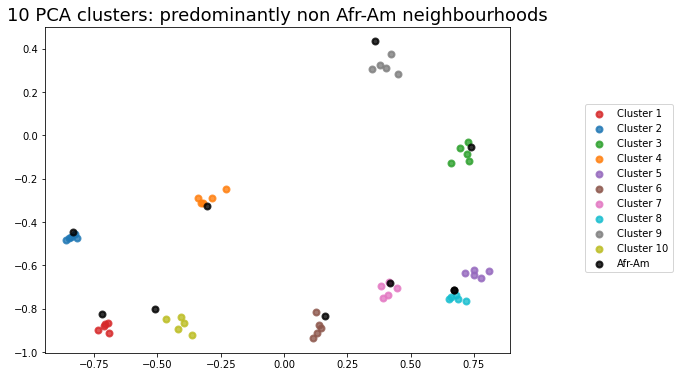

In [484]:
fig, ax = plt.subplots(ncols=1, figsize = (10,6))

lw = 2

for i in range(len(min_B_list)):
    ax.scatter(min_B_list[i][:,0], min_B_list[i][:,1], color=colours[i], alpha=0.8, lw=lw, label=f"Cluster {i+1}")


ax.scatter(C_x, C_y, color="black", alpha=0.8, lw=lw, label=f"Afr-Am")


fig.legend(loc=7, shadow=False, scatterpoints=1)
ax.set_title("10 PCA clusters: predominantly non Afr-Am neighbourhoods", fontsize = 18)


fig.subplots_adjust(right=0.77)  
plt.savefig("Plots/PCA_clusters.png")

plt.show()

Get crime rates from similar white neighbourhoods

In [485]:
# Checking the similarity in terms of crime rate within each cluster 
#pcas = []

crime_rates_pca_neighbourhood_clusters = []
for k in np.arange(0,num_pairs,1):
    current_index = k
    current_cluster = min_B_list[current_index]
    current_indices = min_B_list_index[current_index]

    df_white = df[df_all.IsBlack == 0]

    current_neighbourhood = []
    for i in current_indices:
        current_white = df_white.iloc[[i]]
        current_neighbourhood.append(current_white)

    #Let's double check to be sure that these are the actual pairs which is supposed to be similar: 
    #neighbourhood_pca = []
    #for i in range(len(current_neighbourhood)):
        #white_pca_current = pca.transform(current_neighbourhood[i])
        #neighbourhood_pca.append(white_pca_current)
    #pcas.append(neighbourhood_pca)
    # Now let's look at the crime rates

    df_white_y = df_y[df_all.IsBlack == 0]

    neighbourhood_y = []
    for i in current_indices: 
        current_white_y = df_white_y.iloc[[i]]
        neighbourhood_y.append(current_white_y.ViolentCrimesPerPop.values)
    
    crime_rates_pca_neighbourhood_clusters.append(neighbourhood_y)




In [486]:
crime_rates_pca_neighbourhood_clusters_stds = np.std(crime_rates_pca_neighbourhood_clusters, axis = 1)
np.mean(crime_rates_pca_neighbourhood_clusters_stds)

0.07550947898984253

In [487]:
np.mean(crime_rates_pca_neighbourhood_clusters)

0.1264

Get crime rates for similar black neighbourhoods

In [488]:
crime_rates_pca_black_clusters = []

for k in np.arange(0,num_pairs,1):
    
    current_index = k

    df_black = df[df_all.IsBlack == 1]
    current_black = df_black.iloc[[min_C_list_index[current_index]]]

    # Now let's look at the crime rates
    df_black_y = df_y[df_all.IsBlack == 1]
    current_black_y = df_black_y.iloc[[min_C_list_index[current_index]]]
    crime_rates_pca_black_clusters.append(current_black_y.ViolentCrimesPerPop.values)
    
print(f"Mean black crime rate: {np.mean(crime_rates_pca_black_clusters)}")





Mean black crime rate: 0.21800000000000003


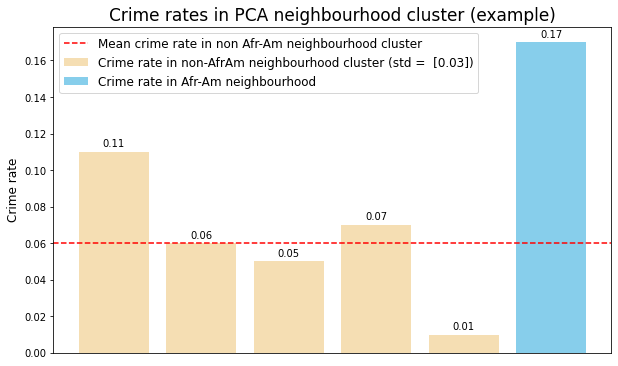

In [489]:
# Plot example of neighbourhood cluster
k = 6

std_neig = crime_rates_pca_neighbourhood_clusters_stds[k]
mean_neig = np.mean((np.asarray(crime_rates_pca_neighbourhood_clusters[k]).ravel()))

fig, ax = plt.subplots(1, 1, figsize = (10,6))

plt.title('Crime rates in PCA neighbourhood cluster (example)', fontsize = 17)


rect = ax.bar(np.arange(1,6,1), np.asarray(crime_rates_pca_neighbourhood_clusters[k]).ravel(), label=f'Crime rate in non-AfrAm neighbourhood cluster (std =  {np.round(std_neig,2)})', color = 'wheat')
ax.axhline(mean_neig, color = 'red', linestyle = '--', label = "Mean crime rate in non Afr-Am neighbourhood cluster")

rect2 = ax.bar(6, crime_rates_pca_black_clusters[k], label=f'Crime rate in Afr-Am neighbourhood', color = 'skyblue')

ax.set_xticks([])

autolabel(rect, ax)
autolabel(rect2, ax)

ax.set_ylabel("Crime rate", fontsize = 12)
ax.legend(fontsize = 12)

plt.savefig("Plots/Neighbourhood_cluster_crime.png")

plt.show()


